# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control, WS17

# Assignment 3 - Eigenfaces and SVD Applications

### Team 
##### Vajra Ganeshkumar
##### Jeeveswaran Kishaan

Let us first setup this notebook so that figures and plots can be shown in it.

In [1]:
try:
    shell = get_ipython()
    shell.enable_pylab("inline")
except NameError:
    pass

import os
import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from scipy.misc import imresize
from scipy.misc import imshow
from scipy.misc import toimage
            
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython
import PIL

**Hint**: Before you start solving the assignment, you might want to check the following *numpy* functions:

```
PIL.Image.open
scipy.misc.imresize
numpy.linalg.eigh
```

## Eigenfaces [30 points]

Eigenvectors have many applications which are not limited to obtaining surface normals from a set of point clouds. In this assignment, you are asked to write your own facial recognition library. Take a look at the following image:

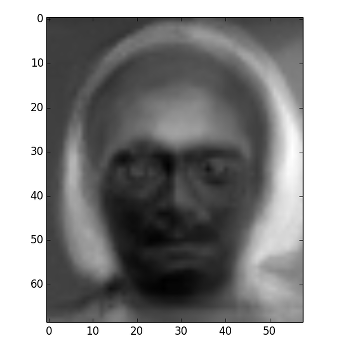

In [2]:
IPython.core.display.Image("images/eigenface.png")

This is what is called an *eigenface*. An eigenface really is nothing else than an eigenvector, in this case reshaped for plotting. Eigenfaces can be used in facial recognition, allowing a robot to distinguish between different persons, but can also be applied to other use cases, such as voice or gesture recognition.

**Your task consists of the following subtasks**:

1. Read the [Scholarpedia article](http://www.scholarpedia.org/article/Eigenfaces) about eigenfaces.
2. Implement the eigenface algorithm described in the article. In particular, create a Python class that exposes (at least) two methods:
    1. A method for calculating eigenfaces given two parameters, namely (i) a set of images and (ii) subject ids that uniquely identify the subjects in the images.
    2. A method that takes one parameter - a list of query faces - and, for each face in the input list, finds the subject id of the most similar face. This method should thus return a list of subject ids.

A dataset for training your recognition algorithm is given in the *data/training* folder. The images in the *data/test* folder should be used for testing the algorithm.

For your implementation, please use the method signatures given below. Use the code under **Testing your code** for loading the images and testing your implementation.

**Hint:** You might find Principal Component Analysis (PCA) useful.

In [3]:
from __future__ import division

class FaceRecognition(object):
    def __init__(self):
        # storing the subject ids of 110 training images in a list
        self.subject_ids = list()      
        # k eigenfaces
        self.faces = None   
        # weights of each face to the eigenvectors
        self.eigenface_weights = None        
        # mean image of input faces
        self.mean_image = []            
        # one weight vector per class, second is for 15 unique classes
        self.unique_eigenface_weights = None  
        # mean image of the training images in a vector format
        self.mean_training_vector = None      

    def eigenfaces(self, image_filenames, subject_ids):
        '''Finds a set of eigenfaces based on the input images.

        Keyword arguments:
        image_filenames -- A list of image filenames
        subject_ids -- A list of IDs that uniquely identify the subjects
                       in the images

        '''
        # storing the subject ids of the training images
        self.subject_ids = subject_ids         
        # Storing the training images in a vector format
        column_vectors = np.empty((45045,0))                               
        for i in range(len(image_filenames)):
            im1 = np.reshape(imread(image_filenames[i]), (45045,1))
            image_array = np.array(im1)
            # shape = (45045,110), train images in a vector form
            column_vectors = np.hstack((column_vectors,image_array))  
        mean_vector = np.mean(column_vectors, axis = 1)
        # storing the mean image in a vector format
        self.mean_training_vector = mean_vector                       
        mean_image_matrix = np.reshape(mean_vector, (-1, 195))
        # storing the mean image in a matrix format
        self.mean_image = mean_image_matrix                          
        # expanding the mean vector into a matrix 
        mean_expanded = np.outer(mean_vector, np.ones(len(image_filenames)))       
        # getting the normalized matrix from the column matrix
        normalized_vector = column_vectors - mean_expanded             
        # Calculating the covariance matrix for PCA
        covariance_matrix = np.dot(normalized_vector.T, normalized_vector)    
        # Getting the eigenvalues and eigenvectors 
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)        
        # Chosen for the highest performance
        k = 22                                              
        # Selecting the k topmost eigenvectors 
        k_largest_eigenvalue_idx = np.argsort(eigenvalues)[::-1][0:k]       
        # low dimension eigenfaces
        W = eigenvectors[:,k_largest_eigenvalue_idx]                          
        # Higher dimensional eigenfaces, shape = (45045, k)
        higher_dimensional_eigenvectors = np.dot(normalized_vector, W)        
        #Normalizing the u_i higher dimensional eigenfaces
        higher_dimensional_eigenvectors = higher_dimensional_eigenvectors / \
                              np.linalg.norm(higher_dimensional_eigenvectors)
        # storing the eigendfaces
        self.faces = higher_dimensional_eigenvectors                          
        weights_of_training_images = np.empty((k,0))
        # calculating the weight matrix for each training image
        for j in range(len(image_filenames)):                                 
            #shape = (15,45045)*(45045, 1) = (15,1)
            weights = np.dot(higher_dimensional_eigenvectors.T, \
                             ((column_vectors[:,j][newaxis].T)- \
                              (mean_vector[newaxis].T)))
            #shape (k,110)
            weights_of_training_images = np.hstack( \
                             (weights_of_training_images, weights))  
        # storing the weights of training images
        self.eigenface_weights = weights_of_training_images                   
        
        # Calculating the weights for each image class
        class_weights_overall = np.empty((k,0))                               
        for cls in range(1,len(set(self.subject_ids))+1): #from 1 to 15
            class_weights = np.empty((k,0))
            for inp in range(len(image_filenames)): #for 110 times
                if self.subject_ids[inp] == cls:
                    class_weights = np.hstack((class_weights, \
                            self.eigenface_weights[:,inp][newaxis].T))
            #shape (k, 15) for 15 classes
            class_weights_overall = np.hstack((class_weights_overall, \
                             np.mean(class_weights, axis=1)[newaxis].T))  
        #  storing the weights of each class
        self.unique_eigenface_weights = class_weights_overall                  

    def recognize_faces(self, image_filenames):
        '''Finds the eigenfaces that have the highest
        similarity to the input images.

        Keyword arguments:
        image_filenames -- A list of image filenames

        Returns:
        recognised_ids -- A list of ids that correspond to the classifier
                          predictions for the input images

        '''
        # list to store the ids of the test images
        recognized_ids = []                   
        # to store the vectors of the test images
        column_vectors2 = np.empty((45045,0))                              
        for i in range(len(image_filenames)):
            # converting the image matrix into vector
            im2 = np.reshape(imread(image_filenames[i]), (45045,1))        
            image_array2 = np.array(im2)                   
            # shape = (45045,110)
            column_vectors2 = np.hstack((column_vectors2,image_array2))   
        
        # Chosen for the best performance
        k = 22                                                             
        weights_of_test_images = np.empty((k,0))
        for j in range(len(image_filenames)):
            #shape = (15,45045)*(45045, 1) = (15,1)
            #====== Calculating the weights of each test image ========
            weights2 = np.dot(self.faces.T, ((column_vectors2[:,j] \
                        [newaxis].T) - (self.mean_training_vector \
                                        [newaxis].T)))
            weights_of_test_images = np.hstack((weights_of_test_images, \
                                                weights2))
        
        # looping through every unknown face
        for q in range(len(image_filenames)):   
            dist = float('inf')
            index = 0            
            #============= FOR 15 DISTINCTIVE CLASSES =================
            # looping through each class of the training image
            for l in range(len(set(self.subject_ids))):  
                # weight of current test image
                x = (weights_of_test_images[:,q][newaxis].T)           
                # weight of current train image class
                y = (self.unique_eigenface_weights[:,l][newaxis].T)    
                # Using the mahalanobis distance instead of 
                # np.linalg.norm as it was giving better performance
                distances_between_query_and_class = scipy.linalg.sqrtm ( \
                        np.dot((x-y).T, (np.dot(np.linalg.inv(np.cov  \
                        (self.eigenface_weights)), (x-y)))))
                # Running the loop to find the least distance and the 
                # index corresponding to it
                if distances_between_query_and_class < dist:
                    dist = float(distances_between_query_and_class)
                    index = l
                    
            # Assigning the index's subject id to the unknown face        
            recognized_ids.append(index+1)
            
        return recognized_ids
        

### Testing your code

In [4]:
import os
import glob

#loading training images
training_image_filenames = sorted(glob.iglob('data/training/*.pgm'))

#loading test images
test_image_filenames = sorted(glob.iglob('data/test/*.pgm'))

#creating a lambda function for extracting filenames;
#the filename of each image is the subject id
subject_number = lambda filename: int(os.path.basename(filename)[7:9])

#extracting the filename using the lambda function
train_subject_ids = list (map(subject_number, training_image_filenames))
test_subject_ids = list (map(subject_number, test_image_filenames))

print 'Test subject ids:', np.array(test_subject_ids)
print '   '
face_recognition = FaceRecognition()
face_recognition.eigenfaces(training_image_filenames, train_subject_ids)
recognized_ids = face_recognition.recognize_faces(test_image_filenames)
print 'Predicted subject ids:', recognized_ids
print '   '
different_results = np.array(test_subject_ids) - np.array(recognized_ids)
positives = (different_results == 0).sum()
accuracy = positives / (len(test_subject_ids) * 1.)
print 'Number of correct predictions = ', positives
print '   '
print 'Prediction accuracy =', accuracy
print '   '

Test subject ids: [ 1  1  1  1  2  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  6  7  7  7  7
  8  8  8  9  9  9  9  9 10 10 10 11 11 11 11 11 12 12 12 13 13 14 14 14 14
 15 15 15 15 15]
   
Predicted subject ids: [1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15]
   
Number of correct predictions =  55
   
Prediction accuracy = 1.0
   


## Line fitting [25 points]

Assume that our robot captures the following point cloud using its Kinect sensor:

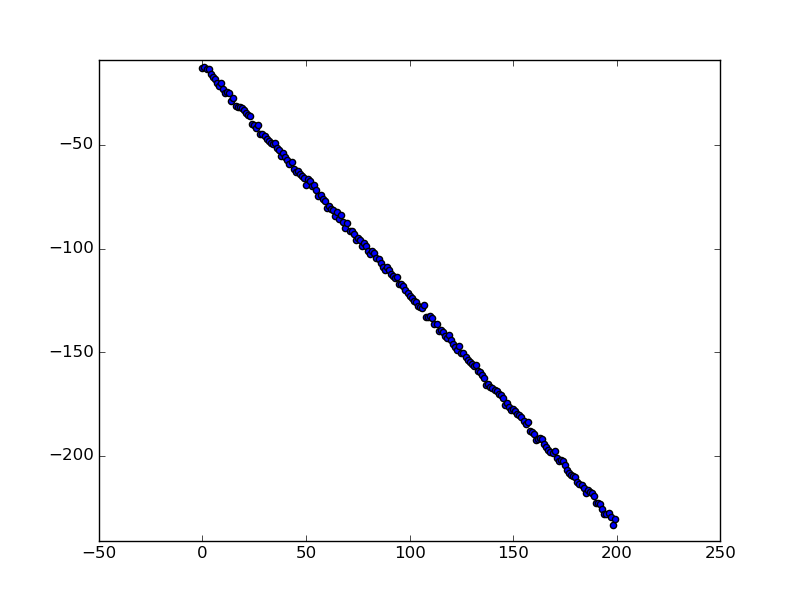

In [5]:
IPython.core.display.Image("images/line.png", embed=True)

Your task in this exercise is to use the SVD for fitting a line to the captured point cloud.

**Hint 1**: Take a look at the slides for the upcoming lecture and understand what the pseudo-inverse is and does.

**Hint 2**: The upcoming lecture slides contain a line fitting example, but we are not after that solution in this exercise; do **not** use that example as a guideline.

### Mathematical model [10 points]

Before we start implementing anything, we need to formalise our problem. Your first task is thus formulating the given line fitting problem mathematically. Please write your formulation in the cell below.



###  Formulation  ###
Consider to fit a straight line **y=mx+c**, to a set of data points.If the data points are collinear, the line would pass through **n** points,such that 
$$ y_{1}  = m  x_{1} + c $$
$$ y_{2}  = m  x_{2} + c $$
$$ y_{3}  = m  x_{3} + c $$
$$\cdot    \cdot  \cdot  $$
$$\cdot    \cdot  \cdot  $$
$$\cdot    \cdot  \cdot  $$
$$ y_{n}  = m  x_{n} + c $$

And this can be written in the matrix form as,
$$ \begin{bmatrix} y_{1} \\  y_{2} \\ y_{3} \\ \cdot \\ \cdot \\ y_{n} \\ \end{bmatrix} = \begin{bmatrix} x_{1}  & 1 \\ x_{2}  & 1 \\ x_{3}  & 1 \\ \cdot & \cdot \\ \cdot & \cdot \\ x_{n}  & 1 \\ \end{bmatrix} \begin{bmatrix} m\\ c \end{bmatrix} $$

Let  

$$A = \begin{bmatrix}
x_{1}  & 1 \\ x_{2}  & 1 \\ x_{3}  & 1 \\ \cdot & \cdot \\ \cdot & \cdot \\x_{n}  & 1 \\ \end{bmatrix}    B =\begin{bmatrix} y_{1} \\ y_{2} \\ y_{3} \\ \cdot \\\cdot \\y_{n} \\ \end{bmatrix} P =\begin{bmatrix} m\\ c \end{bmatrix} $$

So this can be computed as $AP = B$ <br>
The objective is to find a vector p that minimizes the Euclidean distance of the difference $\left \| AP-B \right \|$ <br>
If $P = P^{*}$  is a minimize vector, Then $y = m^{*}x + c^{*}$ is a least square straight-line fit.

To minimize $\left \| AP-B \right \|$ , AP must be equal to $AP^{*}$ <br>where $AP^{*}$ is the orthogonal projection of B on the column space of A. This implies $(AP^{*} - B)$ must be orthogonal to the column space of A .So that,<br>
<br>
 $(AP^{*} -B)AP = 0$ for every vector P in $R^{2}$ 
<br>
    $$(AP)^{T} (AP^{*} -B)= 0$$<br>
<br>
    $$P^{T}A^{T} (AP^{*} -B) = 0 $$<br>
<br>
$$P^{T} (A^{T}AP^{*} -A^{T}B) = 0 $$<br>
<br>
$$(A^{T}AP^{*} - A^{T}B)P = 0 $$ 

So $A^{T}B -A^{T}AP^{*}$ is orthogonal to every vector P in $R^{2}$ and this implies  $(A^{T}AP^{*} - A^{T}B) = 0 $ <br>
<br>
and therefore $$A^{T}AP = A^{T} B    --------------(1)$$   <br>
Which implies that $P^{*}$ satisfies the linear system

$$A^{T}AP = A^{T}B $$ <br> This equation is called the normal equation.And this provides the solution for P as
<br>
$$P = (A^{T}A)^{-1}  A^{T}B         -------------(2)$$    <br>

This equation can be used in the case of least square fit of a polynomial.

To solve the above equation,i.e, to compute $(A^{T}A)^{-1}$ is very complicated. So wew use Singular Value Decomposition to solve the equation. <br>
Using Singular Value Decomposition, a matrix can be decomposed into three matrices such that,

$$A = USV^{T}$$ <br>
Where U and V are orthogonal matrices, and S is a diagonal matrix containing the singular matrix of A.

When we replace A with  $USV^{T}$ and $A^{T}$ with $VS^{T}U^{T}$ in equation(1) we get <br>
  $$(USV^{T})^{T} USV^{T} P = (USV^{T})^{T} B$$  <br>
  <br>
  $$(VS^{T}U^{T}USV^{T})P = (VS^{T}U^{T})B $$   <br>
  <br>
  Since V and U are orthogonal matrices, we know that $$UU^{T} = I$$ , $$VV^{T} = I$$ also $$U^{T} = U^{-1}$$ and $$V^{T} = V^{-1}$$ <br>
<br>
 So now we have,$$(VS^{T}SV^{T})P = VS^{T}U^{T}B$$
 
 Multiplying both sides by $V^{-1}$, we get <br>
<br>
$$(SS^{T}V^{T})P = S^{T}U^{T}B $$     <br>

<br>
 since S is a diagonal matrix, we get $$(SSV^{T})P = SU^{T}B--------------(3)$$ 
 
 Multiplying $S^{-1}$ twice on both the sides of equation(3)
 <br>
 we have, $$V^{T}P = S^{-1}U^{T} B$$ <br>
 Again multiplying by V on both sides,<br>
 we have  $$VV^{T}P = S^{-1}U^{T}B$$   <br>
 <br>
 so now we have,<br>
 $$P = VS^{-1}U^{T}B$$
 <br>
 By solving the above equation $P = VS^{-1}U^{T}B$, we compute the values of m and c. 

### Implementation [15 points]

After formalising the problem mathematically, your task is to implement your solution and obtain the parameters of the line that goes through the point cloud. The individual points of the point cloud are given in the file *data/line.npy*.

Once you fit the line, please plot the points and overlay the line on top of them; you will know that your solution is correct if your line is passing through the points.

m =  -1.10638339964
c =  -11.8581772472


array([ -1.1063834 , -11.85817725])

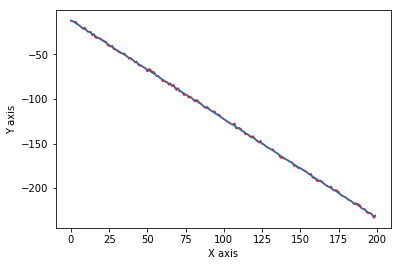

In [6]:
def line_fit(data):
    mat_x = np.array(data)[:,0]
    X = mat_x[np.newaxis].T
    mat_ones =np.ones(np.shape(data)[0])
    A1 = mat_ones[np.newaxis].T
    
    #print 'Matrix A is '
    A = np.hstack((X,A1))
    #print A
    
    mat_y =data[:,1]
    
    
    #print 'Matrix B is '
    B = mat_y[np.newaxis].T
    #print B

    #to find svd
    U,s,Vt = np.linalg.svd(A)
    
    #We have to solve for  P=VS^tU^tB
    
    #s^t is equal to 1/s
    for i in s:
        sigma = 1/s
    sigma_new = np.diag(sigma)
    
   
    zero_mat = np.zeros((2,198))
  
    
    new_sigma = np.hstack((sigma_new, zero_mat))
   

    Ut = np.transpose(U)
    V = np.transpose(Vt)
   
    V_dot_new_sigma = np.dot(V,new_sigma)
   

    V_dot_new_sigma_dot_Ut = np.dot(V_dot_new_sigma,Ut)
    
    #final gives P=VS^tU^tB
    final = np.dot(V_dot_new_sigma_dot_Ut,mat_y)
    
    a = mat_x
    b = final[0]*a + final[1]
    plt.plot(data[:,0],data[:,1],'red')
    plt.plot(a,b)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    print 'm = ',final[0]
    print 'c = ',final[1]
    return final
                                                       

data = np.load ('data/line.npy')
#<line parameters> = line_fit(data)
# plot your line
line_fit(data)


## Parabola fitting [25 points]

Let's suppose that we are given a set of points that roughly lie on a parabola:

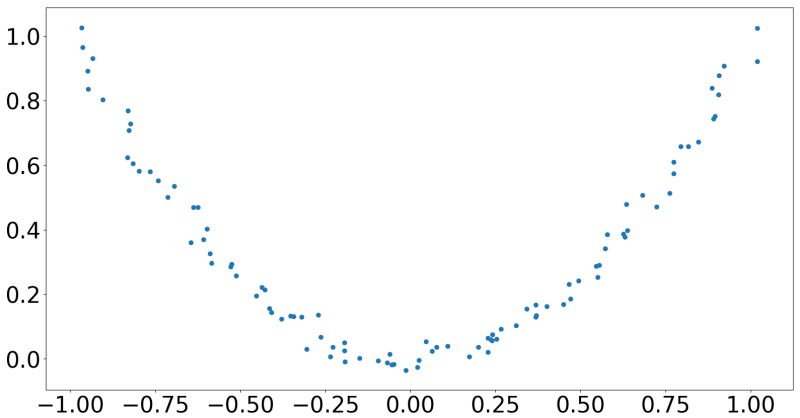

In [7]:
IPython.core.display.Image("images/parabola.png", embed=True)

Your task in this exercise is to use the SVD for fitting a parabola to the given points.

**Hint**: Recall that a parabola is a conic section.

### Mathematical model [10 points]

Just as in the line fitting problem, we need to formalise our problem before we start implementing anything; your first task is thus formulating the parabola fitting problem mathematically. Please write your formulation in the cell below.




### Formulation ###
Consider to fit a parabola **y=a$x^{2}$+bx+c**, to a set of data points.If the data points are collinear, the parabola would pass through **n** points,such that 
<br>
$$ y_{1}  = a  x^{2}_{1} +bx_1 + c $$
$$ y_{1}  = a  x^{2}_{3} +bx_2 + c $$
$$ y_{1}  = a  x^{2}_{1} +bx_3 + c $$
$$\cdot    \cdot  \cdot  $$
$$\cdot    \cdot  \cdot  $$
$$\cdot    \cdot  \cdot  $$
$$ y_{n}  = a  x^{2}_{n} +bx_n + c $$

This can be written in the matrix form as,
$$ \begin{bmatrix} y_{1} \\  y_{2} \\ y_{3} \\ \cdot \\ \cdot \\ y_{n} \\ \end{bmatrix} = \begin{bmatrix} x^{2}_{1} & x_1 & 1\\ x^{2}_{2} & x_2 & 1 \\ x^{2}_{3} & x_3 & 1\\ \cdot & \cdot & \cdot\\ \cdot & \cdot &\cdot\\ x^{2}_{n} & x_n & 1 \end{bmatrix}\begin{bmatrix}a\\ b\\ c\end{bmatrix}$$
<br>
And let,<br>
$$ A = \begin{bmatrix} y_{1} \\  y_{2} \\ y_{3} \\ \cdot \\ \cdot \\ y_{n} \\ \end{bmatrix} B =\begin{bmatrix} x^{2}_{1} & x_1 & 1\\ x^{2}_{2} & x_2 & 1 \\ x^{2}_{3} & x_3 & 1\\ \cdot & \cdot & \cdot\\ \cdot & \cdot &\cdot\\ x^{2}_{n} & x_n & 1 \end{bmatrix} C =\begin{bmatrix}a\\ b\\ c\end{bmatrix}$$


So this can be computed as $AP = B$ <br>
The objective is to find a vector p that minimizes the Euclidean distance of the difference $\left \| AP-B \right \|$ <br>
If $P = P^{*}$  is a minimize vector, Then $y=ax^{2}+bx+c$ is a least square fit.

To minimize $\left \| AP-B \right \|$ , AP must be equal to $AP^{*}$ <br>where $AP^{*}$ is the orthogonal projection of B on the column space of A. This implies $(AP^{*} - B)$ must be orthogonal to the column space of A .So that,<br>
<br>
 $(AP^{*} -B)AP = 0$ for every vector P in $R^{2}$ 
<br>
    $$(AP)^{T} (AP^{*} -B)= 0$$<br>
<br>
    $$P^{T}A^{T} (AP^{*} -B) = 0 $$<br>
<br>
$$P^{T} (A^{T}AP^{*} -A^{T}B) = 0 $$<br>
<br>
$$(A^{T}AP^{*} - A^{T}B)P = 0 $$ 

So $A^{T}B -A^{T}AP^{*}$ is orthogonal to every vector P in $R^{2}$ and this implies  $(A^{T}AP^{*} - A^{T}B) = 0 $ <br>
<br>
and therefore $$A^{T}AP = A^{T} B    --------------(1)$$   <br>
Which implies that $P^{*}$ satisfies the linear system

$$A^{T}AP = A^{T}B $$ <br> This equation is called the normal equation.And this provides the solution for P as
<br>
$$P = (A^{T}A)^{-1}  A^{T}B         -------------(2)$$    <br>

This equation can be used in the case of least square fit of a polynomial.

To solve the above equation,i.e, to compute $(A^{T}A)^{-1}$ is very complicated. So wew use Singular Value Decomposition to solve the equation. <br>
Using Singular Value Decomposition, a matrix can be decomposed into three matrices such that,

$$A = USV^{T}$$ <br>
Where U and V are orthogonal matrices, and S is a diagonal matrix containing the singular matrix of A.

When we replace A with  $USV^{T}$ and $A^{T}$ with $VS^{T}U^{T}$ in equation(1) we get <br>
  $$(USV^{T})^{T} USV^{T} P = (USV^{T})^{T} B$$  <br>
  <br>
  $$(VS^{T}U^{T}USV^{T})P = (VS^{T}U^{T})B $$   <br>
  <br>
  Since V and U are orthogonal matrices, we know that $$UU^{T} = I$$ , $$VV^{T} = I$$ also $$U^{T} = U^{-1}$$ and $$V^{T} = V^{-1}$$ <br>
<br>
 So now we have,$$(VS^{T}SV^{T})P = VS^{T}U^{T}B$$
 
 Multiplying both sides by $V^{-1}$, we get <br>
<br>
$$(SS^{T}V^{T})P = S^{T}U^{T}B $$     <br>

<br>
 since S is a diagonal matrix, we get $$(SSV^{T})P = SU^{T}B--------------(3)$$ 
 
 Multiplying $S^{-1}$ twice on both the sides of equation(3)
 <br>
 we have, $$V^{T}P = S^{-1}U^{T} B$$ <br>
 Again multiplying by V on both sides,<br>
 we have  $$VV^{T}P = S^{-1}U^{T}B$$   <br>
 <br>
 so now we have,<br>
 $$P = VS^{-1}U^{T}B$$
 
By solving the above equation $P = VS^{-1}U^{T}B$, we compute the values of a,b and c

### Implementation [15 points]

After formalising the problem, your task is to implement your solution and obtain the parameters of the parabola that goes through the point cloud. The individual points of the point cloud are given in the file *data/parabola.txt*.

Once you fit the parabola, please plot the points and overlay the parabola on top of them; you will know that your solution is correct if your parabola is passing through the points.

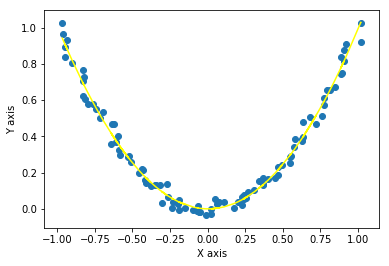

a =  1.0006120792
b =  -0.00841739342854
c =  -0.000880590198168


array([  1.00061208e+00,  -8.41739343e-03,  -8.80590198e-04])

In [8]:
def parabola_fit(data): 
    #values of x
    mat_x = np.array(data)[:,0]
    #values of x^2
    mat_x2 = mat_x**2
    
    X = mat_x[np.newaxis].T
    X2 =mat_x2[np.newaxis].T
    
    #Creates a matrix with ones
    mat_ones =np.ones(np.shape(data)[0])
    z = mat_ones[np.newaxis].T
    a = np.hstack((X2,X))
    
    #Matrix A
    A = np.hstack((a,z))
    #print A

    #Matrix B
    mat_y = data[:,1]
    B = mat_y[np.newaxis].T
    #print B

    #Finding SvD
    U,s,Vt = np.linalg.svd(A)
    
    #We have to solve for  P=VS^tU^tB

    #s^t is equal to 1/s
    for i in s:
        sigma = 1/s

    sigma_new = np.diag(sigma)
   
    zero_mat = np.zeros((3,97))
    
    new_sigma = np.hstack((sigma_new, zero_mat))
    

    Ut = np.transpose(U)
    
    V = np.transpose(Vt)
    
    V_dot_new_sigma = np.dot(V,new_sigma)
    #print V_dot_new_sigma

    V_dot_new_sigma_dot_Ut = np.dot(V_dot_new_sigma,Ut)
    #print V_dot_new_sigma_dot_Ut
 
    #final gives  P=VS^tU^tB
    final = np.dot(V_dot_new_sigma_dot_Ut,mat_y)
    #print final
   
    a = mat_x
    b = final[0]*mat_x2 + final[1]*mat_x + final[2]
    plt.plot(a,b,'yellow')
    plt.scatter(data[:,0],data[:,1])
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()
    print 'a = ',final[0]
    print 'b = ',final[1]
    print 'c = ',final[2]
    return final
   
data = np.loadtxt('data/parabola.txt')
parabola_fit(data)